# Read an SHP file and project it into discrete gridpoints

In this example we will put both atmospheric gridded data and SHP data into the same custom grid of our choice. 

We first load useful libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import geopandas as gp
from scipy.interpolate import griddata
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import rioxarray
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.patches import Circle,RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


While we will have the SHP as a geopandas, using its boundaries for plotting partial results

In [3]:
df = gp.read_file('../../DATA/Fire_Perimeter.shp')
# df = df.to_crs(epsg=4326)
x_min, y_min, x_max, y_max = df.total_bounds
x_min

-121.77762215499996

The shapefile describes in this example a river: 

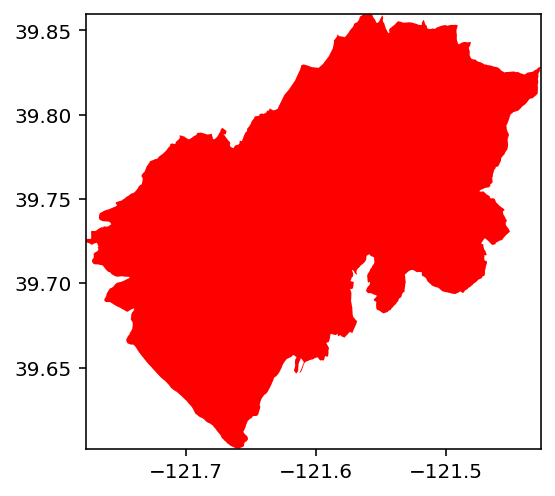

In [4]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
df.plot(ax=ax, color='red');

We now define a shapefile grid with the rectangles containing the original features, on which we will project these features. 

In [5]:
n_cells=100
cell_size = (x_max-x_min)/n_cells
grid_cells = []

for x0 in np.arange(x_min, x_max+cell_size, cell_size ):
    for y0 in np.arange(y_min, y_max+cell_size, cell_size):
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )

We now convert this shapefile into geopandas and we calculate the position of each centroid of each rectangle of the grid. 

In [6]:
cell = gp.GeoDataFrame(grid_cells, columns=['geometry'])
cell['centroids'] = cell['geometry'].centroid

The cells look like as follows 

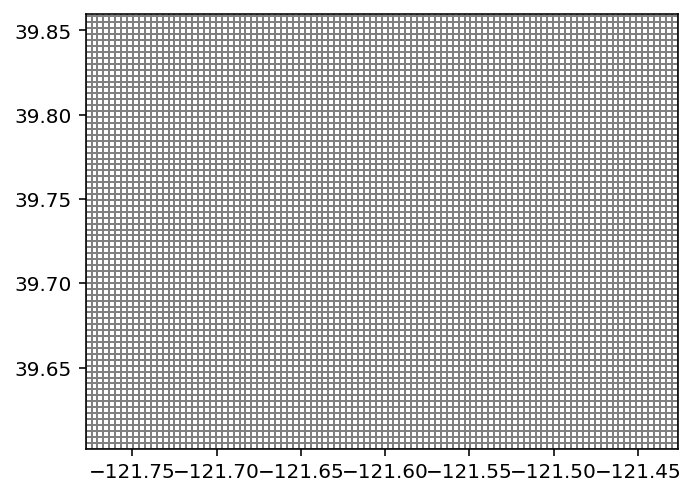

In [7]:
fig,ax = plt.subplots(1,1,dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
cell.plot(ax=ax, facecolor="none", edgecolor='grey');

The function sjoin allows us to merge the cells and the geopandas. 

In [8]:
merged = gp.sjoin(df, cell)

We now assign a value to each of the cells based on aggregation 

In [9]:
merged['aggr']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'aggr'] = dissolve.aggr.values
cell

,geometry,centroids,aggr
0,"POLYGON ((-121.78113 39.60192, -121.78113 39.6...",POINT (-121.77938 39.60368),NaN
1,"POLYGON ((-121.78113 39.60543, -121.78113 39.6...",POINT (-121.77938 39.60719),NaN
2,"POLYGON ((-121.78113 39.60895, -121.78113 39.6...",POINT (-121.77938 39.61070),NaN
3,"POLYGON ((-121.78113 39.61246, -121.78113 39.6...",POINT (-121.77938 39.61421),NaN
4,"POLYGON ((-121.78113 39.61597, -121.78113 39.6...",POINT (-121.77938 39.61772),NaN
...,...,...,...
7645,"POLYGON ((-121.42649 39.84772, -121.42649 39.8...",POINT (-121.42473 39.84947),NaN
7646,"POLYGON ((-121.42649 39.85123, -121.42649 39.8...",POINT (-121.42473 39.85298),NaN
7647,"POLYGON ((-121.42649 39.85474, -121.42649 39.8...",POINT (-121.42473 39.85649),NaN
7648,"POLYGON ((-121.42649 39.85825, -121.42649 39.8...",POINT (-121.42473 39.86001),NaN


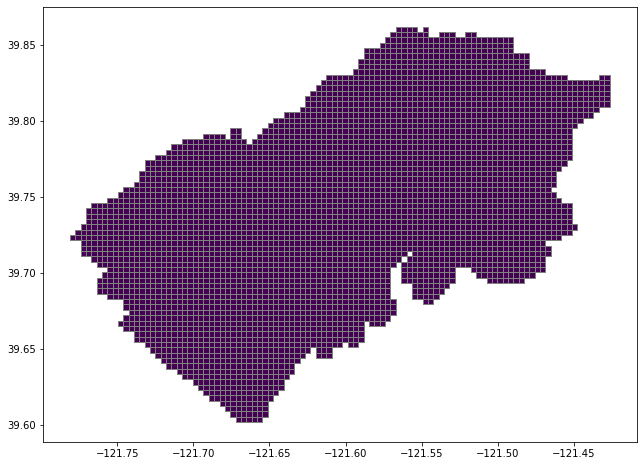

In [13]:
cell.plot(column='aggr', figsize=(12, 8), cmap='viridis', vmax=100, edgecolor="grey");